# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is an extremely powerful **technique** used in data analysis, particularly for reducing the dimensionality of datasets while preserving crucial information. It transforms the original variables into a set of new, uncorrelated variables called **principal components** that capture most of the data variance. PCA is that one of those elegant ideas from Linear Algebra that has a host of applications in:

1. **Dimensionality Reduction / Data Compression**

2. **Data Visualization and Exploratory Data Analysis**

3. **Uncovering latent variables/themes/concepts**

4. **Create uncorrelated features/variables as inputs for prediction model**

5. **Noise reduction in the dataset**

# Principal Component Analysis (PCA) Examples
1. **Image Compression**

2. **Financial Data Analysis**

3. **Spectral Analysis**

4. **Customer Segmentation**


### Why is normalization necessary in PCA?

The principal components are supplied with a normalized version of the original predictors. This is because the original predictors may have different scales. For example: Imagine a data set with variables measuring units as gallons, kilometers, light years, etc. The scale of variances in these variables will obviously be large. Performing PCA on un-normalized variables will lead to exponentially large loadings for variables with high variance. In turn, this will lead to the dependence of a principal component on the variable with high variance. This is undesirable.

As shown in the image below, PCA was run on a data set twice (with unscaled and scaled predictors). This data set has ~40 variables. You can see a variable Item_MRP dominates first principal component and a variable Item_Weight dominates the second principal component. This domination prevails due to high value of variance associated with a variable. When the variables are scaled, we get a much better representation of variables in 2D space.

<img src="normalization.png" alt="Normalization" width="500"/>



### Now, let's apply PCA on one of its most capable task: Image Compression

Here I am going to analyze a single image. Remember that to apply PCA on any image (dataset), we must begin by defining the Covariance Matrix. After that we will compute the eigenvalues (the variance magnitude) and their corresponding eigenvectors (the variance direction) of this covariance matrix. Each of these eigenvectors will be a principle component. To perform dimensionality reduction, we will take k pricipal components associated to k biggest eigenvalues, and transform the original data by projecting it onto the direction of these principal components (eigenvectors).

In [14]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
from PIL import Image
import scipy.sparse.linalg

Firstly, since the original images are RBG. For the sake of explaining what PCA is doing, we convert to grayscale images.

In [27]:
def convert_to_grayscale_and_save(source_folder, dest_folder="dataset"):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    imgs = []
    for filename in os.listdir(source_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # Open the image
            image_path = os.path.join(source_folder, filename)
            with Image.open(image_path) as img:
                # Convert to grayscale
                gray_img = img.convert('L')
                
                # Save the grayscale image
                gray_filename = f"gray_{filename}"
                gray_path = os.path.join(dest_folder, gray_filename)
                gray_img.save(gray_path)
                
                # Append to list as numpy array
                imgs.append(np.array(gray_img))
    
    # Convert list to numpy array
    imgs = np.array(imgs)
    print(f"Converted {len(imgs)} images to grayscale and saved in '{dest_folder}' folder.")
    print(f"Array shape: {imgs.shape}")
    
    return imgs

folder = "CatDog"
grayscale_images = convert_to_grayscale_and_save(folder)


Converted 55 images to grayscale and saved in 'dataset' folder.
Array shape: (55, 64, 64)


In [28]:
height, width = grayscale_images[4].shape

print(f"dataset has {len(grayscale_images)} images of size {height}x{width}")

dataset has 55 images of size 64x64


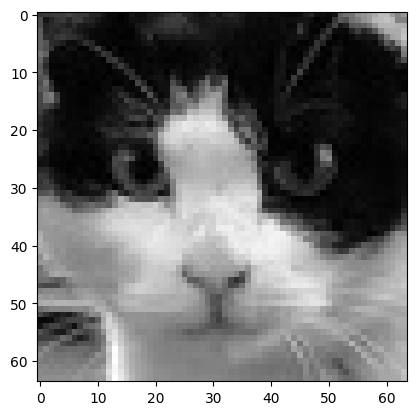

In [29]:
plt.imshow(grayscale_images[2], cmap='gray')

When working with images, you can consider each pixel as a variable.

In order to apply PCA for dimensionality reduction you will need to flatten each image into a single row vector. 

The resulting array will have 55 rows, one for each image, and 64x64=4096 columns.

In [30]:
imgs_flatten = np.array([img.reshape(-1) for img in grayscale_images])

imgs_flatten.shape

(55, 4096)

Now that we have the images in the correct shape, let's apply PCA in the flattened dataset.

If we consider each pixel (column) as a variable, and each image (rows) as an obervation we will have 55 observations of 4096 variables, $X_1, X_2, \ldots, X_{4096}$ so that
$$\mathrm{imgs\_flatten} = \begin{bmatrix} x_{1,1} & x_{1,2} & \ldots & x_{1,4096}\\
                                           x_{2,1} & x_{2,2} & \ldots & x_{2,4096} \\
                                           \vdots & \vdots & \ddots & \vdots \\
                                           x_{55,1} & x_{55,2} & \ldots & x_{55,4096}\end{bmatrix}$$


To compute PCA, we first need to find the covariance matrix


$$\Sigma = \begin{bmatrix}Var(X_1) & Cov(X_1, X_2) & \ldots & Cov(X_1, X_{4096}) \\
                          Cov(X_1, X_2) & Var(X_2) & \ldots & Cov(X_2, X_{4096})\\
                          \vdots & \vdots & \ddots & \vdots \\
                          Cov(X_1,X_{4096}) & Cov(X_2, X_{4096}) &\ldots & Var(X_{4096})\end{bmatrix}$$

In [31]:
def center_data(Y):
    """
    Y (ndarry): input data. Shape (n_observations, n_pixels)
    X (ndarray): centered data. Shape (n_observations, n_pixels)    
    """
    mean_vector = np.mean(Y, axis=0)
    mean_matrix = np.repeat(mean_vector, Y.shape[0], axis=0)
    mean_matrix = np.reshape(mean_matrix, Y.shape, order='F')
    
    X = Y - mean_matrix
    return X

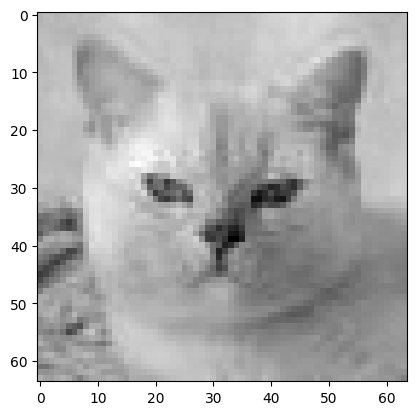

In [33]:
X = center_data(imgs_flatten)
plt.imshow(X[0].reshape(height, width), cmap='gray')

The covariance matrix can be found by appliying the dot product between $X^T$ and $X$, and divide by the number of observations minus 1.

In [34]:
def covariance_matrix(X):
    cov_matrix = np.dot(X.T, X)
    cov_matrix = cov_matrix / (X.shape[0]-1)
    
    return cov_matrix

cov_matrix = covariance_matrix(X)
print(cov_matrix.shape)

(4096, 4096)


It has been proven that at most 55 eigenvalues of `cov_matrix` will be different from zero, which is the smallest dimension of the data matrix `X`. Thus, for computational efficiency, you will only be computing the first biggest 55 eigenvalues $\lambda_1, \ldots, \lambda_{55}$ and their corresponding eigenvectors $v_1, \ldots, v_{55}$.

The outputs of this scipy function are exactly the same as the ones from `np.linalg.eig`, except eigenvalues are ordered in decreasing order, so if you want to check out the largest eigenvalue you need to look into the last position of the vector. 

In [54]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(cov_matrix, k=55)
print(eigenvalues[-10:])

[ 297975.51248328  372742.87119322  414722.64859182  463460.41507112
  823820.22376983  860323.62908656 1001483.14559747 1546805.56662182
 2482088.59042476 4331856.17272863]


In [55]:
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

print(f'Ten largest eigenvalues: {eigenvalues[:10]}')

Ten largest eigenvalues: [4331856.17272863 2482088.59042476 1546805.56662182 1001483.14559747
  860323.62908656  823820.22376983  463460.41507112  414722.64859182
  372742.87119322  297975.51248328]


Each of the eigenvectors you found will represent one principal component. The eigenvector associated with the largest eigenvalue will be the first principal component, the eigenvector associated with the second largest eigenvalue will be the second principal component, and so on. 

It is pretty interesting to see that each principal component usually extracts some relevant features, or patterns from each image. In the next cell you will be visualizing the first sixteen components

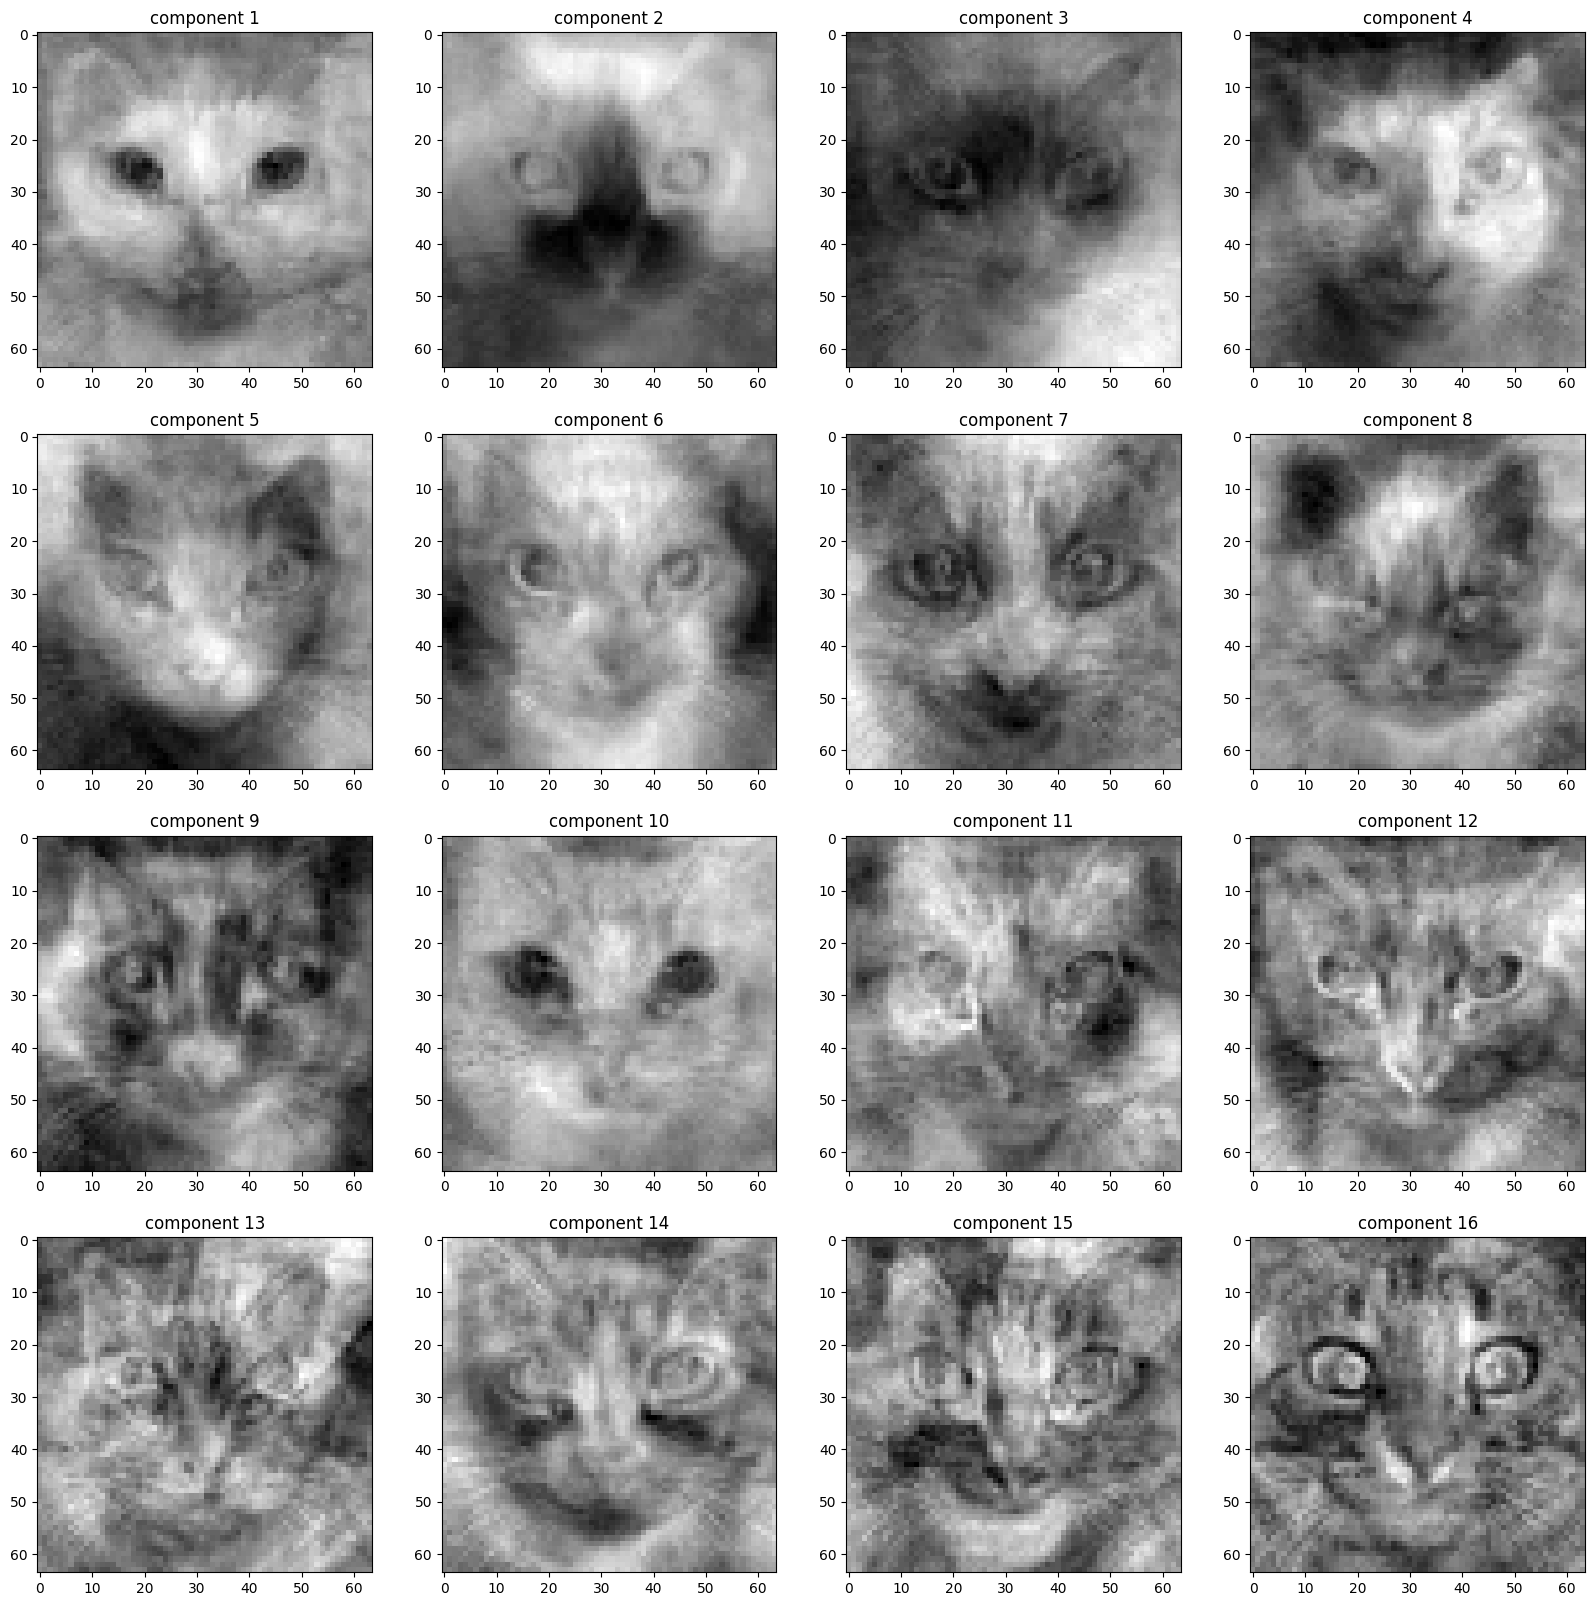

In [37]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for n in range(4):
    for k in range(4):
        ax[n, k].imshow(eigenvectors[:, n*4+k].reshape(height, width), cmap='gray')
        ax[n, k].set_title(f'component {n*4+k+1}')  

Now that we have the first 55 eigenvalue-eivenvector pairs, we can transform our data to reduce the dimensions. Remember that our data originally consisted of 4096 variables. Suppose we want to reduce that to just 2 dimensions, then all we need to do to perform the reduction with PCA is take the dot product between the centered data and the matrix $\boldsymbol{V}=\begin{bmatrix} v_1 & v_2 \end{bmatrix}$, whose columns are the first 2 eigenvectors, or principal components, associated to the 2 largest eigenvalues.

In [38]:
def PCA(X, eigenvectors, k):
    """
    X (ndarray): original data matrix (n_observations, n_pixels)
    eigenvectors (ndarray): matrix of eigenvectors (each column is one eigenvector). the k-th column corresponds to the k-th largest eigenvalue
    k (int): number of components to keep
    
    return X_pca (ndarray): data matrix in the new space (n_observations, k)
    """
    
    V = eigenvectors[:, :k]
    X_pca = np.dot(X, V)
    
    return X_pca

In [39]:
X_pca2 = PCA(X, eigenvectors, 2)
print(X_pca2.shape)

(55, 2)


C:\Users\Admin\AppData\Local\Temp\ipykernel_47256\1671676690.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, cmap='viridis', alpha=0.7)


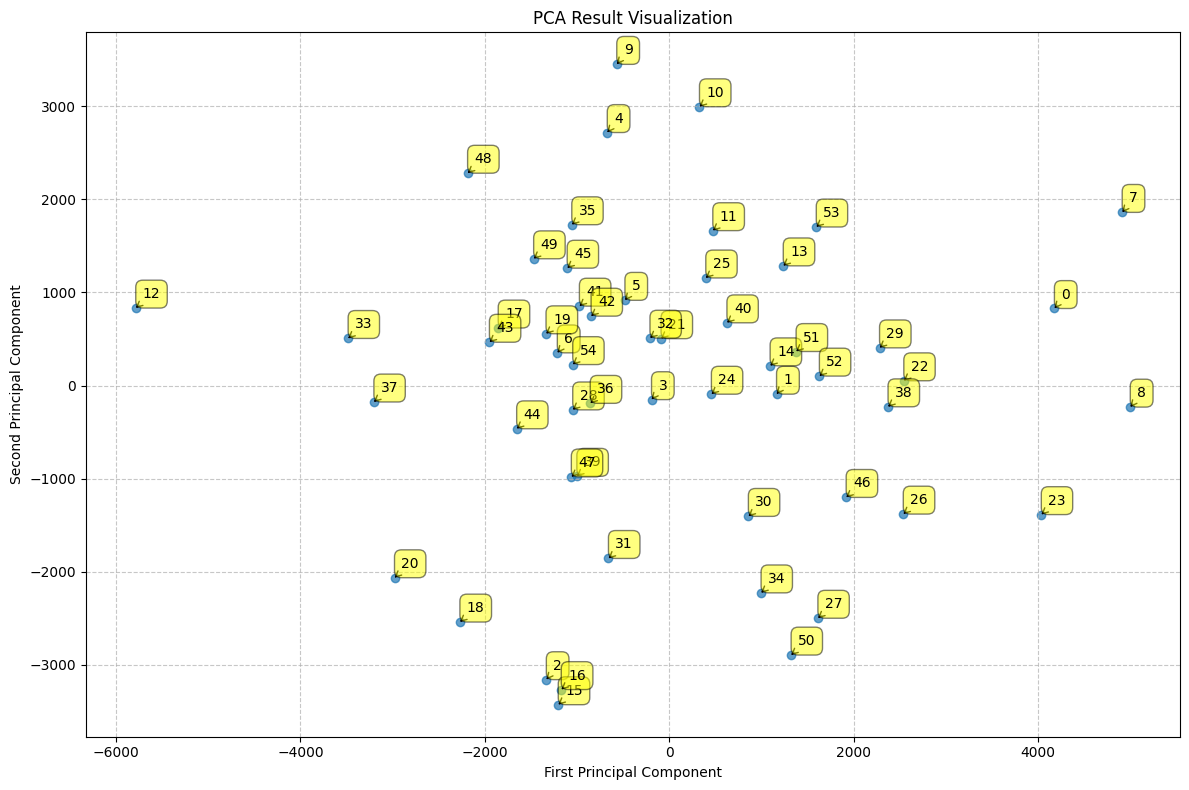

In [40]:
def plot_pca_results(X_pca2, labels=None, n_to_annotate=None):
    plt.figure(figsize=(12,8))
    scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Result Visualization')
    
    if labels is not None:
        plt.colorbar(scatter, label='Class')
    
    # Annotate points with their index
    if n_to_annotate is None:
        n_to_annotate = len(X_pca2)
    for i in range(min(n_to_annotate, len(X_pca2))):
        plt.annotate(str(i), (X_pca2[i, 0], X_pca2[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', ha='left', va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                     arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_pca_results(X_pca2)

If two points end up being close to each other in this representation, it is expected that the original pictures should be similar as well. Same goes for the opposite.

Text(0.5, 1.0, 'Image 15')

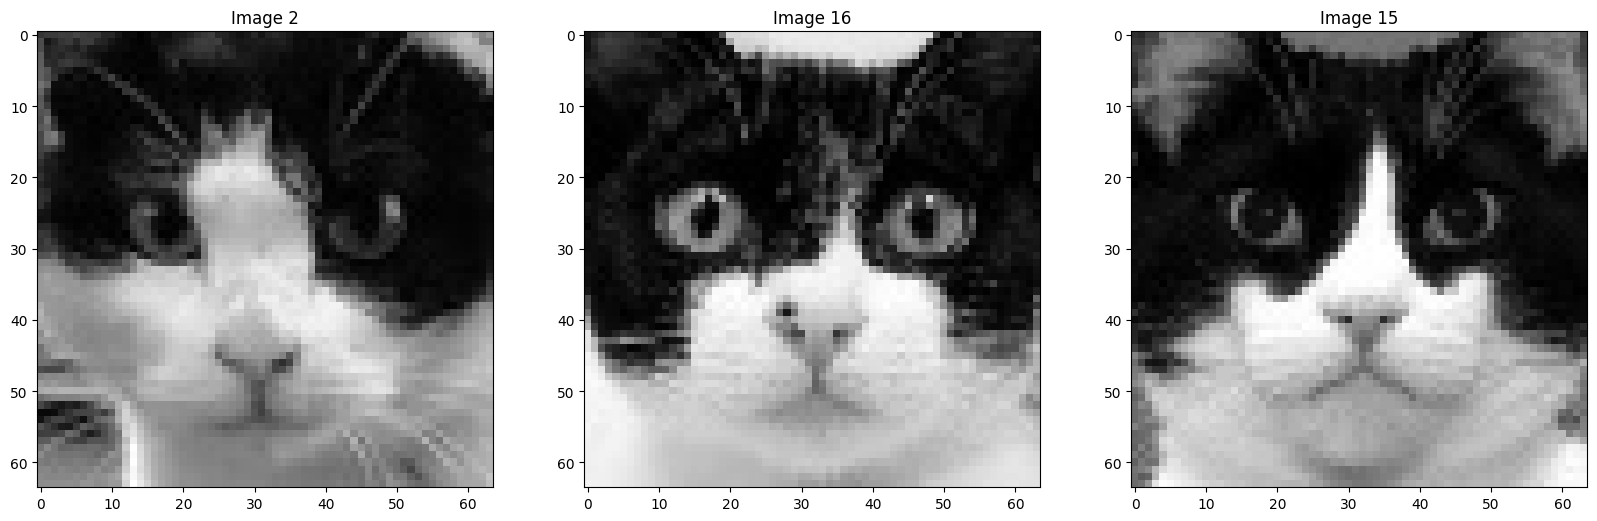

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(grayscale_images[2], cmap='gray')
ax[0].set_title('Image 2')
ax[1].imshow(grayscale_images[16], cmap='gray')
ax[1].set_title('Image 16')
ax[2].imshow(grayscale_images[15], cmap='gray')
ax[2].set_title('Image 15')

Text(0.5, 1.0, 'Image 9')

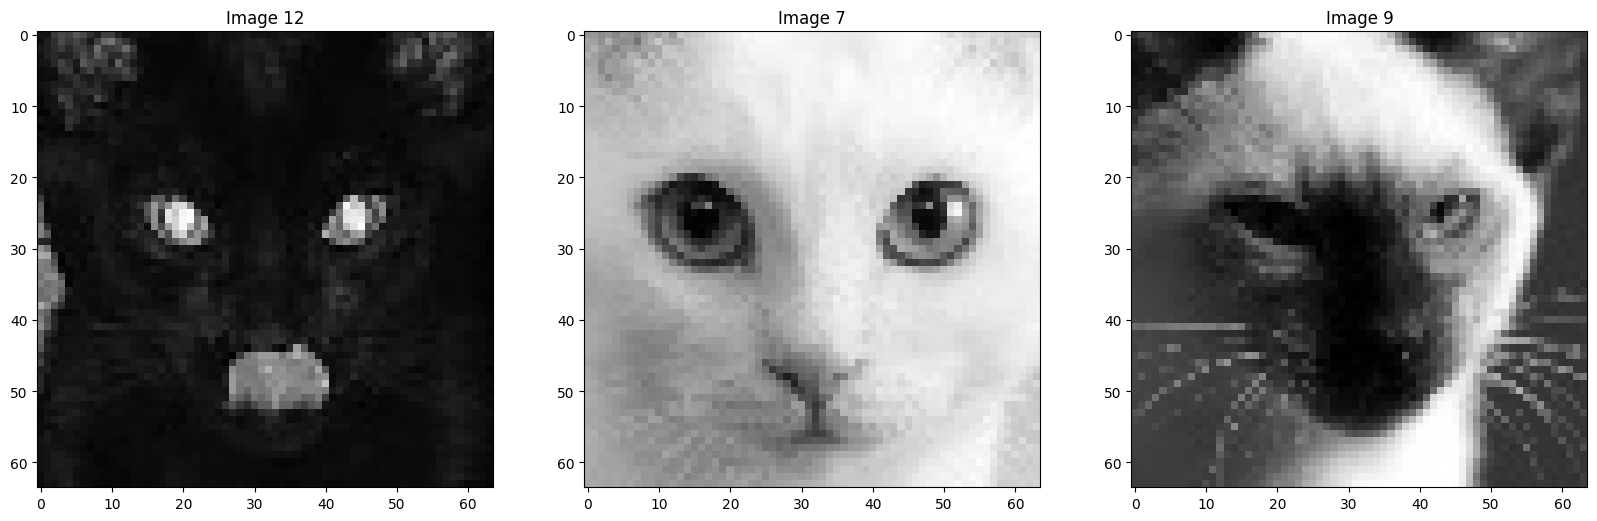

In [43]:
fig, ax =plt.subplots(1, 3, figsize=(20,6))
ax[0].imshow(grayscale_images[12], cmap='gray')
ax[0].set_title('Image 12')
ax[1].imshow(grayscale_images[7], cmap='gray')
ax[1].set_title('Image 7')
ax[2].imshow(grayscale_images[9], cmap='gray')
ax[2].set_title('Image 9')   

When we compress the images using PCA, we are losing some information because we are using fewer variables to represent each observation. 

A natural question arises: how many components do we need to get a good reconstruction of the image? In other words, what would be the optimal 'k'?

A cool thing is that with a simple dot product we can transform the data after applying PCA back to the original space. This means that we can reconstruct the original image from the transformed space and check how distorted it looks based on the number of components we kept.

Suppose we obtained the matrix $X_{pca}$ by keeping just two eigenvectors, then $X_{pca} = \mathrm{X}\underbrace{\left[v_1\  v_2\right]}_{\boldsymbol{V_2}}$.

To transform the images back to the original variables space all we need to do is take the dot product between $X_{red}$ and $\boldsymbol{V_2}^T$. If we were to keep more components, say $k$, then simply replace $\boldsymbol{V_2}$ by $\boldsymbol{V_k} = \left[v_1\ v_2\ \ldots\ v_k\right]$. Notice that we can't make any combination we like, if we reduced the original data to just $k$ components, then the recovery must consider only the first $k$ eigenvectors, otherwise we will not be able to perform the matrix multiplication.

In [44]:
def reconstruct_image(X_pca, eigenvectors):
    X_reconstructed = np.dot(X_pca, eigenvectors[:,:X_pca.shape[1]].T)
    
    return X_reconstructed

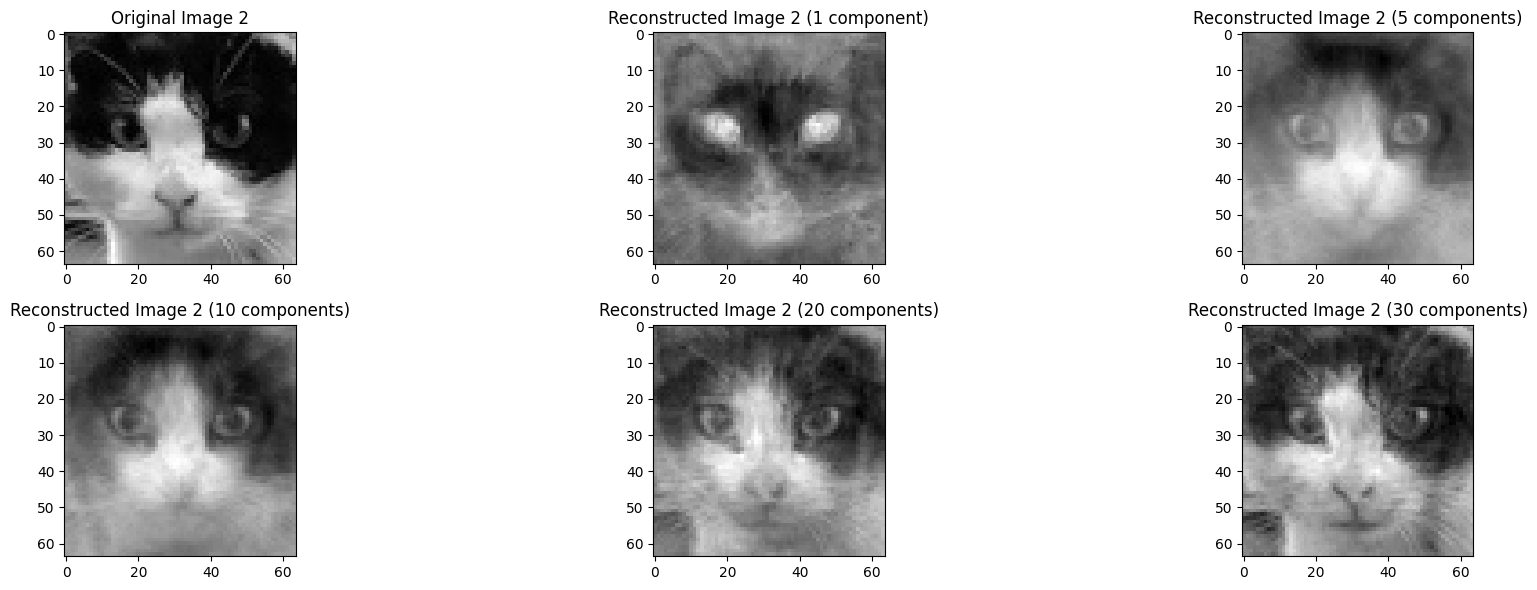

In [45]:
X_pca1 = PCA(X, eigenvectors, 1)
X_pca5 = PCA(X, eigenvectors, 5)
X_pca10 = PCA(X, eigenvectors, 10)
X_pca20 = PCA(X, eigenvectors, 20)
X_pca30 = PCA(X, eigenvectors, 30)

X_rec1 = reconstruct_image(X_pca1, eigenvectors)
X_rec5 = reconstruct_image(X_pca5, eigenvectors)
X_rec10 = reconstruct_image(X_pca10, eigenvectors)
X_rec20 = reconstruct_image(X_pca20, eigenvectors)
X_rec30 = reconstruct_image(X_pca30, eigenvectors)

fig, ax = plt.subplots(2, 3, figsize=(20, 6))
ax[0][0].imshow(grayscale_images[2], cmap='gray')
ax[0][0].set_title('Original Image 2')
ax[0][1].imshow(X_rec1[2].reshape(height, width), cmap='gray')
ax[0][1].set_title('Reconstructed Image 2 (1 component)')
ax[0][2].imshow(X_rec5[2].reshape(height, width), cmap='gray')
ax[0][2].set_title('Reconstructed Image 2 (5 components)')
ax[1][0].imshow(X_rec10[2].reshape(height, width), cmap='gray')
ax[1][0].set_title('Reconstructed Image 2 (10 components)')
ax[1][1].imshow(X_rec20[2].reshape(height, width), cmap='gray')
ax[1][1].set_title('Reconstructed Image 2 (20 components)')
ax[1][2].imshow(X_rec30[2].reshape(height, width), cmap='gray')
ax[1][2].set_title('Reconstructed Image 2 (30 components)')
plt.tight_layout()


Evidently, as the number of components increases, the reconstructed image looks more and more as the original one. Even with as little as 1 component we can are least identify where the relevant features such as eyes and nose are located. 

## The Explained Variance

when deciding how many components to use for the dimensionality reduction, one good criteria to consider is the explained variance. 

The explained variance is measure of how much variation in a dataset can be attributed to each of the principal components (eigenvectors). In other words, it tells us how much of the total variance is “explained” by each component. 

In PCA, the first principal component, i.e. the eigenvector associated to the largest eigenvalue, is the one with greatest explained variance. As we might remember from the lectures, the goal of PCA is to reduce the dimensionality by projecting data in the directions with biggest variability. 

In practical terms, the explained variance of a principal component is the ratio between its associated eigenvalue and the sum of all the eigenvalues. So, for our example, if we want the explained variance of the first principal component we will need to do $\frac{\lambda_1}{\sum_{i=1}^{55} \lambda_i}$

Next, let's plot the explained variance of each of the 55 principal components, or eigenvectors. Don't worry about the fact that we only computed 55 eigenvalue-eigenvector pairs, recall that all the remaining eigenvalues of the covariance matrix are zero, and thus won't add enything to the explained variance.

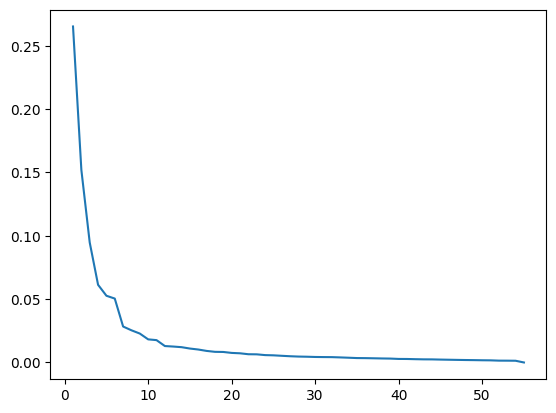

In [48]:
explained_variance = eigenvalues / sum(eigenvalues)
plt.plot(range(1, len(explained_variance)+1), explained_variance)

As we can see, the explained variance falls pretty fast, and is very small after the 20th component.

A good way to decide on the number of components is to keep the ones that explain a very high percentage of the variance, for example 95%. 

For an easier visualization we can plot the cumulative explained variance.

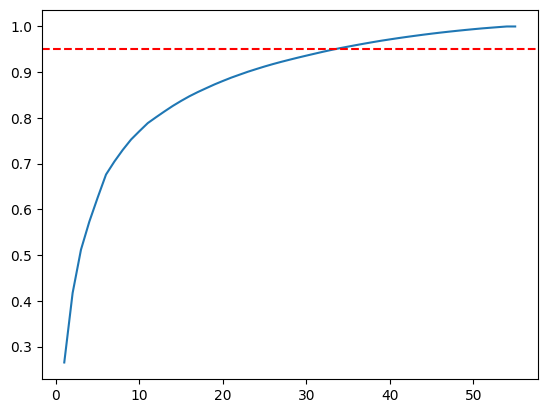

In [49]:
explained_cum_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(explained_cum_variance)+1), explained_cum_variance)
plt.axhline(y=0.95, color='r', linestyle='--')

In red we can see the 95% line. This means that if we want to be able to explain 95% of the variance of we data we need to keep 35 principal components. 

Let's see how some of the original images look after the reconstruction when using 35 principal components 

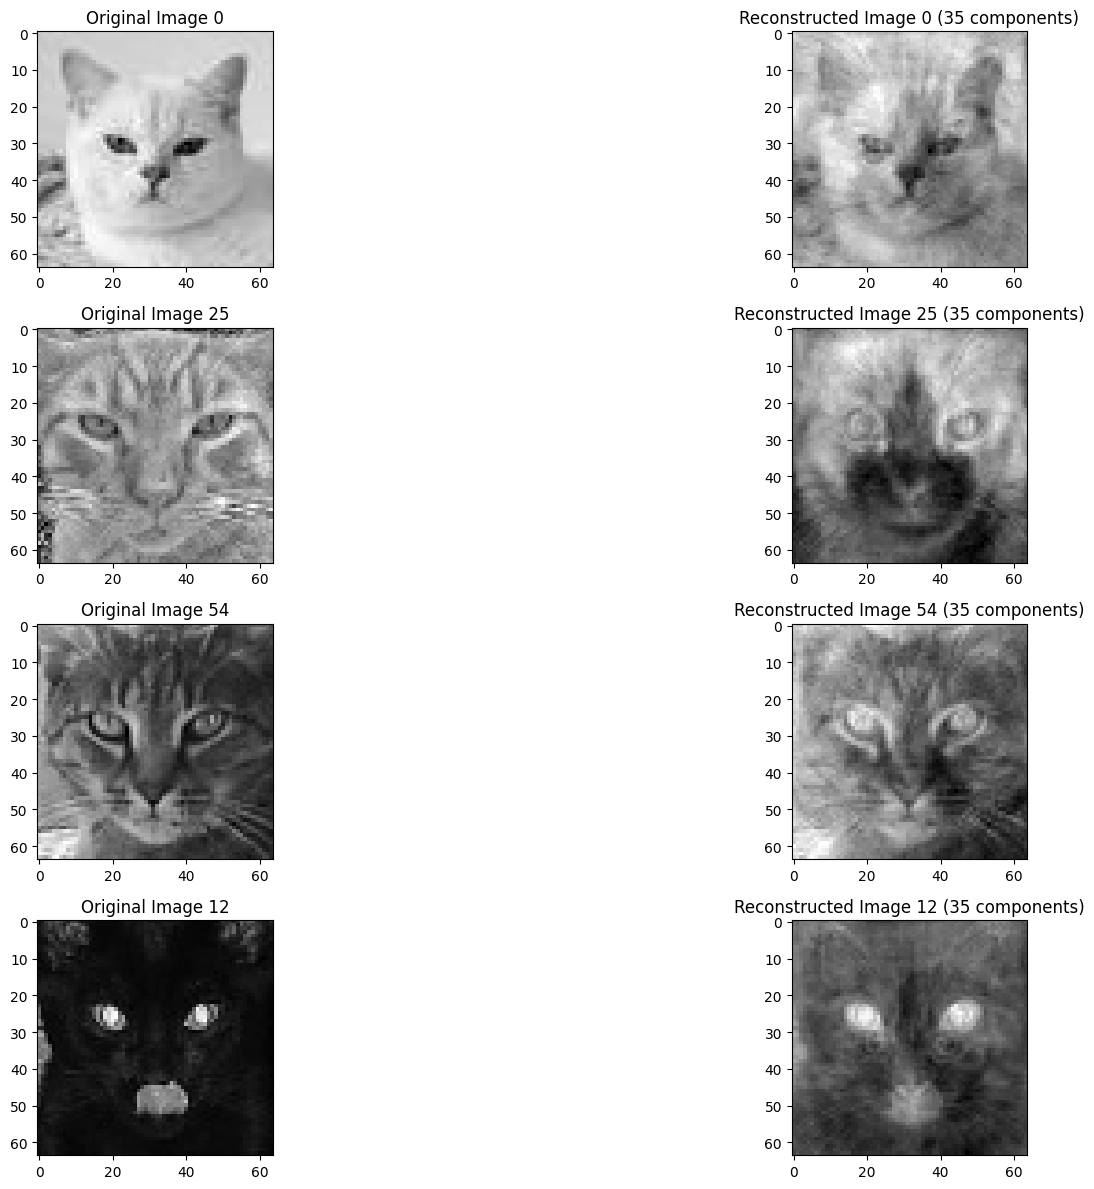

In [52]:
X_pca35 = PCA(X, eigenvectors, 35)
X_rec35 = reconstruct_image(X_pca35, eigenvectors)

fig, ax = plt.subplots(4, 2, figsize=(20, 12))
ax[0][0].imshow(grayscale_images[0], cmap='gray')
ax[0][0].set_title('Original Image 0')
ax[0][1].imshow(X_rec35[0].reshape(height, width), cmap='gray')
ax[0][1].set_title('Reconstructed Image 0 (35 components)')

ax[1][0].imshow(grayscale_images[25], cmap='gray')
ax[1][0].set_title('Original Image 25')
ax[1][1].imshow(X_rec35[25].reshape(height, width), cmap='gray')
ax[1][1].set_title('Reconstructed Image 25 (35 components)')

ax[2][0].imshow(grayscale_images[54], cmap='gray')
ax[2][0].set_title('Original Image 54')
ax[2][1].imshow(X_rec35[54].reshape(height, width), cmap='gray')
ax[2][1].set_title('Reconstructed Image 54 (35 components)')

ax[3][0].imshow(grayscale_images[12], cmap='gray')
ax[3][0].set_title('Original Image 12')
ax[3][1].imshow(X_rec35[12].reshape(height, width), cmap='gray')
ax[3][1].set_title('Reconstructed Image 12 (35 components)')
plt.tight_layout()

Most of these reconstructions look pretty good, and you were able to save a lot of memory by reducing the data from 4096 variables to just 35!